In [24]:
import os
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm
from datetime import datetime

os.chdir("../")
from src import dataset
from src import build_pred_model as build
plt.rcParams['figure.figsize'] = 14, 8

In [2]:
dataset.PAIR = "MATICBUSD"
dataset.KW_LIST = ["Matic"]
start = dataset.Date(2021, 2, 22, 17)
end = dataset.Date(2021, 12, 10, 17)

In [3]:
file = "{}/dataset/{}_{:d}_{:d}.csv".format(os.getcwd(), dataset.PAIR , start.get_timestamp(), end.get_timestamp())
if not os.path.exists(file):
    df = dataset.create_dataset(start, end, path="{}/dataset/".format(os.getcwd()))
else:
    df = read_csv(file)

In [4]:
df.tail(1000)

Open time  Open price  High price  Low price  Close price  \
3852  1627876800000     1.04614     1.06445    1.03714      1.04954   
3853  1627880400000     1.04902     1.05907    1.04854      1.04972   
3854  1627884000000     1.04972     1.07566    1.04569      1.07500   
3855  1627887600000     1.07500     1.07999    1.06604      1.07182   
3856  1627891200000     1.07256     1.07500    1.05215      1.05390   
...             ...         ...         ...        ...          ...   
4847  1631458800000     1.34200     1.35200    1.32400      1.33200   
4848  1631462400000     1.33200     1.34400    1.33000      1.33800   
4849  1631466000000     1.33800     1.34800    1.33300      1.34400   
4850  1631469600000     1.34400     1.34700    1.32600      1.33500   
4851  1631473200000     1.33500     1.34300    1.32600      1.34100   

         Volume  Number of trades  Matic  
3852  1498865.1              4554   78.0  
3853   724601.8              2074   78.0  
3854  1062077.9              4237   76.0  
3855   710976.6              3073   73.0  
3856  1248209.9              4389   75.0  
...         ...               ...    ...  
4847  1341838.2              3693   34.0  
4848   729983.7              2033   28.0  
4849   456297.6              1576   37.0  
4850   770626.4              2320   46.0  
4851   407820.8              1480    NaN  

[1000 rows x 8 columns]

In [5]:
Model = build.BuildModel("dataset\MATICBUSD_1614009600000_1639152000000.csv", "MATIC_CUDA", load=True)

In [11]:
Model.SEQ_LEN = 24 # X h to predict one hour
Model.TRAIN_SPLIT = 0.85 # X % training, 1-X % testing
Model.BATCH_SIZE = 64 # Tensorflow param
Model.EPOCHS = 30 # Tensorflow param
Model.VALIDATION_SPLIT = 0.15 # Tensorflow param

In [12]:
Model._normalization()

In [13]:
Model.X_train.shape

(4103, 23, 7)

In [ ]:
Model.build_model()

In [28]:
Model.train_model()

Epoch 1/30
54/54 [==============================] - 6s 39ms/step - loss: 0.0138 - accuracy: 0.5193 - val_loss: 0.0023 - val_accuracy: 0.9901
Epoch 2/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0052 - accuracy: 0.5629 - val_loss: 0.0022 - val_accuracy: 0.9901
Epoch 3/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0047 - accuracy: 0.5711 - val_loss: 0.0021 - val_accuracy: 0.9901
Epoch 4/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0045 - accuracy: 0.5892 - val_loss: 0.0023 - val_accuracy: 0.9901
Epoch 5/30
54/54 [==============================] - 1s 23ms/step - loss: 0.0045 - accuracy: 0.6009 - val_loss: 0.0022 - val_accuracy: 0.9901
Epoch 6/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0042 - accuracy: 0.5980 - val_loss: 0.0022 - val_accuracy: 0.9901
Epoch 7/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0041 - accuracy: 0.6077 - val_loss: 0.0023 - val_accuracy: 0.9901
Epoch 8/30
54

In [14]:
Model.evaluate_model()

23/23 [==============================] - 1s 7ms/step - loss: 0.0030 - accuracy: 0.8841


AttributeError: 'NoneType' object has no attribute 'history'

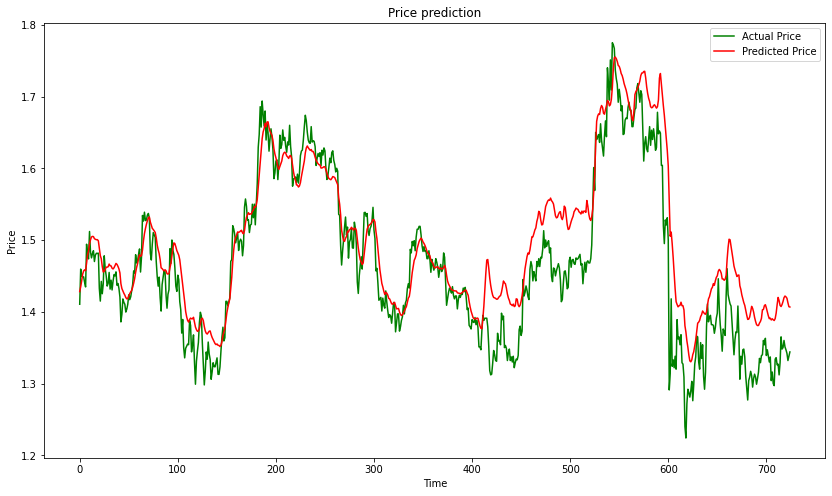

In [15]:
Model.test_prediction()

In [47]:
Model.save_model()

INFO:tensorflow:Assets written to: ../saved_model/MATIC_CUDA\assets


INFO:tensorflow:Assets written to: ../saved_model/MATIC_CUDA\assets


In [16]:
X_pred = Model.X_test
time = 24*10
for i in tqdm(range(time)):
    X_pred = np.vstack([X_pred, np.expand_dims(np.vstack([X_pred[-1, 1:, :], Model.model.predict(X_pred)[-1]]), axis=0)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:38<00:00,  6.30it/s]


In [17]:
y_pred_inverse = Model.scaler.inverse_transform(X_pred[-time:, -1, :])

In [18]:
y = np.vstack([Model.scaler.inverse_transform(Model.model.predict(Model.X_test)), y_pred_inverse])

In [19]:
plt.plot(Model.scaler.inverse_transform(Model.y_test)[:, 0], label="Actual Price", color='green')
plt.plot(y[:, 0], label="Predicted Price", color='red')
 
plt.title('Price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [25]:
fig = go.Figure(data=go.Ohlc(x=Model.df['Open time'][:len(Model.X_test)].apply(lambda x: datetime.fromtimestamp(x/1000)),
                    open=y_pred_inverse[:, 0],
                    high=y_pred_inverse[:, 1],
                    low=y_pred_inverse[:, 2],
                    close=y_pred_inverse[:, 3]))
fig.show()